In [1]:
from djccx.frd.readfrd import readfrd
from matplotlib import pyplot as plt
from validation.FullExperimental import FullExperimental
import os, glob
import numpy as np

In [2]:
params = {
            "geo" : {
                        "t_n" : 3.073400,
                        "t_l" : 0.427120,
                        "Lx"  : 30,
                        "Ly"  : 25,
                        "meshsizefactor" : 1.2,
                    },
            "sim" : {
                        "disp" : 0.5,
                    },
            "tensile" : {
                        "disp" : 2.0,
                    },
        }



In [3]:
epsilon_tensile = params["tensile"]["disp"] / params["geo"]["Ly"]
eps_span = np.linspace(0, epsilon_tensile, 4)
print(eps_span)

[0.         0.02666667 0.05333333 0.08      ]


In [4]:
from AnalyticalLayers.models import Tau_model

In [5]:
composition = [
        ["Y", "Y"],
        ["Y", "X"],
        ["Y", "SX"],
        ["Y", "SY"],
        ["Y", "SX" , "SY"],
        ["Y", "X"  , "SY"]
    ]
ni = [ len(c) for c in composition ]

In [6]:
tn = params["geo"]["t_n"]
tl = params["geo"]["t_l"]
Lx = params["geo"]["Lx"]

tt = [ Tau_model(tn,tl,ini) for ini in ni ]
tt = np.array(tt)


In [7]:
Lx

30

In [8]:
tt

array([4.78188, 4.78188, 4.78188, 4.78188, 5.63612, 5.63612])

In [9]:
df_exp = FullExperimental() 

In [10]:
df_exp.pop("Eb [GPa]")
df_exp.pop("Et [GPa]")
df_exp.pop("Vc")

Name
TFP1    0.178
TFP2    0.164
TFP3    0.135
TFP4    0.144
TFP5    0.146
TFP6    0.180
Name: Vc, dtype: float64

In [11]:
df_exp

% e              St [MPa]               t [mm]            \
          mean       std        mean        std      mean       std   
Name                                                                  
TFP1  0.123306  0.009827  279.103333  14.337700  5.266667  0.057735   
TFP2  0.087556  0.002840  153.360000   0.473181  4.700000  0.000000   
TFP3  0.087444  0.002164  137.113333   4.996812  4.833333  0.057735   
TFP4  0.095472  0.005491  184.396667   1.356515  4.700000  0.000000   
TFP5  0.089889  0.013757   99.990000   9.790138  5.700000  0.000000   
TFP6  0.089083  0.010304  104.513333   7.708893  5.600000  0.000000   

         b [mm]              Sb [MPa]                  layers  
           mean       std        mean        std               
Name                                                           
TFP1  25.600000  0.100000  134.996667  18.942693          [Y]  
TFP2  25.566667  0.057735  117.430000  15.759607       [Y, X]  
TFP3  25.400000  0.173205  128.053333   5.337905      [Y, SX]  
TFP4  25.666667  0.152753  141.703333   7.525386      [Y, SY]  
TFP5  25.166667  0.152753  107.433333   3.902939  [Y, SX, SY]  
TFP6  25.033333  0.635085  114.306667  11.800790   [Y, X, SY]

In [12]:
St = df_exp["St [MPa]"]["mean"]

In [13]:
St = np.array([254.673131,  # TFP1
               164.532862,  # TFP2
               137.191090,  # TFP3
               117.631645,  # TFP4
               109.185026,  # TFP5
               117.132917	]) # TFP6

In [14]:
import pandas as pd

results = pd.read_csv("output.csv")

In [15]:
frds = glob.glob("output/*/tensile/*.frd")
inps = glob.glob("output/*/tensile/*.inp")
stress_test = [ p.replace("tensile","stress") for p in inps ]

frds.sort()
inps.sort()

In [16]:
# createe folders 
for p in stress_test:
    try:
        os.makedirs(p, exist_ok=True)
    except:
        pass

In [17]:
from djccx.inp.inp import inp

Wine está instalado. Versión: wine-9.0
Wine is installed. Calculix will be run with windows binary


In [18]:
import numpy as np

In [19]:
St_layers = {
    "X"   : 481.083731,  # MPa
    "SX"  : 80.120493,  # MPa
    "Y"   : 667.663085,   # MPa
    "SY"  : 127.036236, # MPa
    "nucleo" : 0.0,
}

St_TFP = [ 254.673131    , 
          164.532862     , 
          137.191090	 ,
           117.631645    , 
            109.185026   , 
            117.132917 ]

Sb_TFP = [254.673131,
           200.317858,
           137.191090,
           117.631645,
           109.185026,
           117.132917 ]


In [94]:
 
def PostProcessing(TPF):

    inp_f = inp(inps[TPF])
    ifrd = readfrd(frds[TPF])
    LAYERS =  inp_f.elements

    YLs = inp_f.select_regex(".*YL_.*","nset")
    icomp = [ *composition[TPF][::-1] , "nucleo", *composition[TPF] ]

    ti = np.array([tl for i in range(len(icomp))])
    ti[len(icomp)//2] = tn

    A = ti*Lx
    print(icomp)

    rr = []
    for data in ifrd["data_blocks"]:
        F2s = []
        S2s = []
        
        # ========================
        # Principal Stress
        # ========================
        P1s = []

        for idx in range(len(LAYERS)):
            nodes = LAYERS[idx].GetUniqueNodes(inp_f.nodes)
            y = nodes["y"]
            
            ymin = y.min()
            ymax = y.max() 
            yL = ymax - ymin
            ymin_new = y.min() + yL/3
            ymax_new = y.max() - yL/3
            nodes = nodes[(nodes["y"]>ymin_new) & (nodes["y"]<ymax_new)]

            z = nodes["z"]
            zunq = np.unique(z)
            zmean = np.mean(zunq)
            znear = np.argmin(np.abs(zunq - zmean))
            z = zunq[znear]
            nodes =  nodes[nodes["z"] == z]

            P1max = np.max(data.loc[nodes.index]["P1"])
            P1s.append(P1max)

            # take line

        P1s = np.array(P1s)
        # ========================
        # Force By layers
        # ========================
        
        for idx in range(len(YLs)):
            df = data.loc[YLs[idx].id_nodes]
            F2 = df["F2"].sum()
            F2s.append(F2)
            S2 = F2/A[idx]
            S2s.append(S2)

        S2s = np.array(S2s)
        # ========================
        # Total Force
        # ========================

        F2 = data["F2"]
        y = data["y"]
        ymean = F2.mean()
        A_ly1 = Lx*tt[TPF]
        F2_tot = F2[y>y.mean()].sum()
        sigma_tot = F2_tot.sum()/A_ly1

        r = { 
            "Sapl_by_layers" : S2s,
            "Sapl" : sigma_tot,
            "layers" : icomp,
            "P1" : P1s,
        }
        rr.append(r)

    Sapl_time = [ r["Sapl"] for r in rr ]
    
    ly = len(LAYERS)

    Ls = [ ]
    for i in range(ly):
        Ls.append([ r["Sapl_by_layers"][i] for r in rr ])

    P1s =[]
    for i in range(ly):
        P1s.append([ r["P1"][i] for r in rr ])

    # fig = plt.figure(figsize=(4,4))
    # colors = ["r","g","b"]
    # for i,L in enumerate(Ls):
    #     if i>len(Ls)//2:
    #         break
    #     ly = rr[0]["layers"][i]
    #     St_layer = St_layers[ly]
    #     if ly != "nucleo":

    #         plt.plot(100*eps_span,L,'.-',label=r"$\sigma_{max}^{"+ly + "}$",
    #                     color=colors[i])
    #         plt.axhline(St_layer,linestyle="--",color=colors[i],label=r"$\sigma_{"+ly+"}$")


    # plt.plot(100*eps_span,Sapl_time,'.-',label=r"$\sigma_{apl}$",color="b")
    # plt.legend()
    # plt.ylabel(r"$\sigma_{max}^{i}$ [MPa]",fontsize=12)
    # plt.xlabel(r"$\epsilon \ [\%]$")
    # #  Mpa vertical line
    # # plt.axvline(St_TFP[TPF],linestyle="--",color="k")
    # plt.title("TFP "+str(TPF) + " | Composition: " + str(icomp))
    # plt.grid()

    fig = plt.figure(figsize=(4,4))
    colors = ["r","g","b"]
    for i,L in enumerate(P1s):
        if i>len(Ls)//2:
            break
        ly = rr[0]["layers"][i]
        St_layer = St_layers[ly]
        if ly != "nucleo":
            label = r"$\sigma_{max}^{"+ly + "} $ (FEM)"
            plt.plot(Sapl_time,L,'.-',label=label,
                        color=colors[i])
            
            nSt = round(St_layer,1)
            label = r"$\sigma_{"+ly+"} = " + str(nSt) + r" \ MPa$ (analytical)"
            plt.axhline(St_layer,
                        linestyle="--",
                        color=colors[i],
                        label=label)
            
    plt.ylabel(r"$\sigma_{max}^{i}$ [MPa]",fontsize=12)
    plt.xlabel(r"$\sigma_{apl}$ [MPa]")
    #  Mpa vertical line

    #
    # plt.axvline(St_TFP[TPF],linestyle="--",
    #             color="k",
    #             label=r"$\sigma_{TPF"+str(TPF+1)+"} = " + str(St_TFP[TPF]) + r" \ MPa$")
    # 
    # Lo cambiamos por una franja con error 10%
    ylims = plt.gca().get_ylim()
    plt.fill_betweenx([-100,1000],St_TFP[TPF]*0.95,St_TFP[TPF]*1.05,alpha=0.2,color="k",label=r"$ \sigma_{TPF"+str(TPF+1)+"} \pm 10 \%$")
    plt.ylim(ylims)
    plt.grid()
    # outside

    
    ly = len(LAYERS)
    P1s_end = [ P1[-1] for P1 in P1s ]
    P1s_end = np.array(P1s_end)
    P1s_end = P1s_end[ : ly%2 +1  ]

    sigma_an =  [ St_layers[ly] for ly in icomp[:ly%2 +1 ] ]

    # print("P1s_end",P1s_end)
    # print("sigma_an",sigma_an)
    # print("S_apl_end",Sapl_time[-1])
    # print("list",(Sapl_time[-1]/ P1s_end)*sigma_an)
    S_prediction = np.min( (Sapl_time[-1]/ P1s_end)*sigma_an )
    # print("S_prediction",S_prediction)

    # vertical 
    plt.axvline(S_prediction,linestyle="--",color="m",label=r"$\sigma_{pred} = " + str(round(S_prediction,1)) + r" \ MPa$")

    error_rel = 100*abs(S_prediction - St_TFP[TPF])/St_TFP[TPF]

    plt.title("TFP "+str(TPF+1) + " | Composition: " + str(icomp) + " | error: " + str(round(error_rel,1)) + " %")

    plt.legend( bbox_to_anchor=(1.05, 1), 
        loc='upper left', 
        borderaxespad=0.)
    
    fig = plt.figure(figsize=(4,4))
    plt.plot(100*eps_span,Sapl_time,'.-',label=r"$\sigma_{nom}$",color="k")
    

    alphas = []
    for i,L in enumerate(P1s):
        if i>len(Ls)//2:
            break
        ly = rr[0]["layers"][i]
        St_layer = St_layers[ly]
        if ly != "nucleo":
            label = r"$\sigma_{max}^{"+ly + "} $ "
            plt.plot(100*eps_span,L,'.-',label=label,
                        color=colors[i])
            
            alphas.append(L[-1]/(100*eps_span[-1]))
            
            nSt = round(St_layer,1)
            label = r"$\sigma_{"+ly+"}$ "
            plt.axhline(St_layer,
                        linestyle="--",
                        color=colors[i],
                        label=label)
    
    eps_pred = np.min(sigma_an/np.array(alphas))
    plt.axvline(eps_pred, linestyle="--",
                color="m",
                label=r"$\epsilon_{pred}$")

    plt.grid()

    plt.ylabel(r"$\sigma_{max}^{i}$ [MPa]",fontsize=12)
    plt.xlabel(r"$\epsilon \ [\%]$")

    # alpha_bk
    alpha_bk = S_prediction/eps_pred

    plt.axhline(alpha_bk*eps_pred, linestyle="--",
                color="k",
                label=r"$\sigma_{TFP" + str(TPF+1) + "} $")
    
    plt.legend( bbox_to_anchor=(1.05, 1),   
        loc='upper left', 
        borderaxespad=0.)

['Y', 'Y', 'nucleo', 'Y', 'Y']


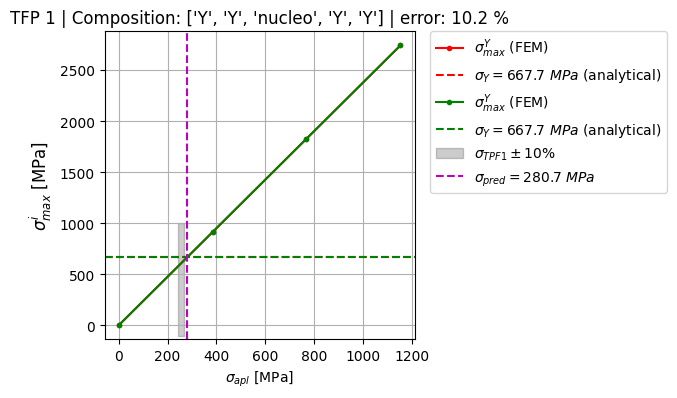

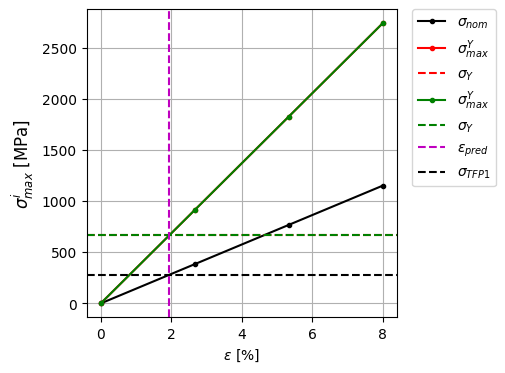

In [95]:
PostProcessing(0)

['X', 'Y', 'nucleo', 'Y', 'X']


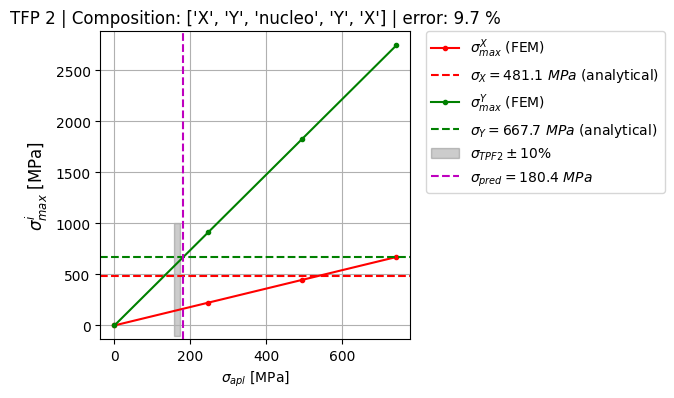

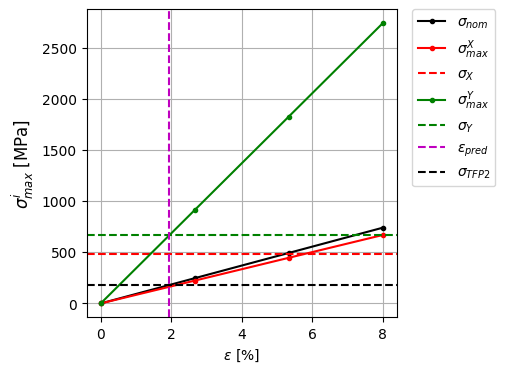

In [96]:
PostProcessing(1)

['SX', 'Y', 'nucleo', 'Y', 'SX']


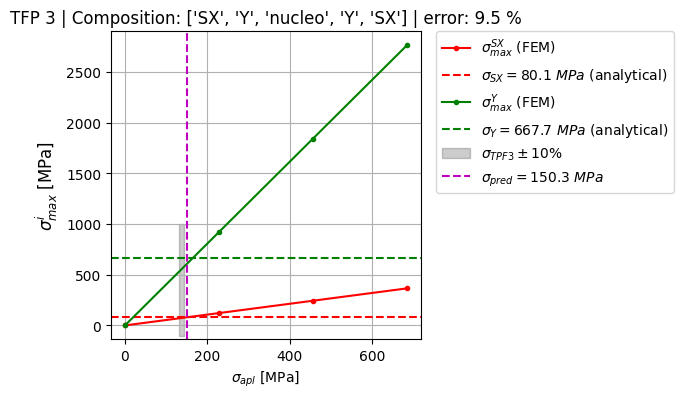

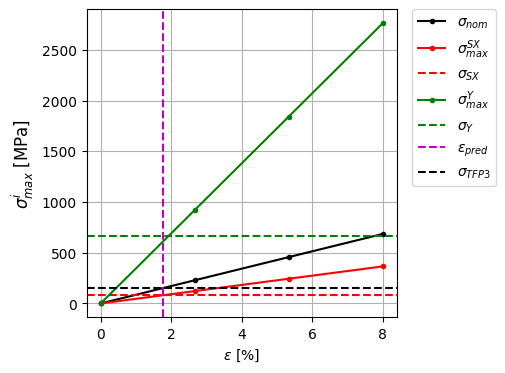

In [97]:
PostProcessing(2)

['SY', 'Y', 'nucleo', 'Y', 'SY']


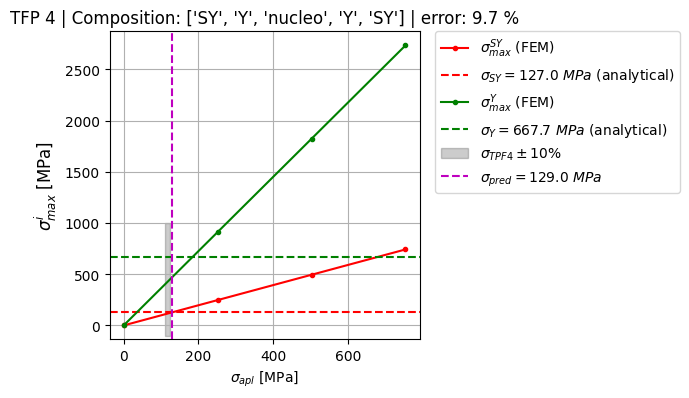

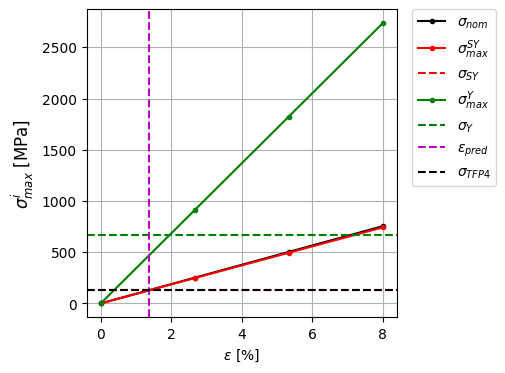

In [98]:
PostProcessing(3)

['SY', 'SX', 'Y', 'nucleo', 'Y', 'SX', 'SY']


ValueError: operands could not be broadcast together with shapes (2,) (3,) 

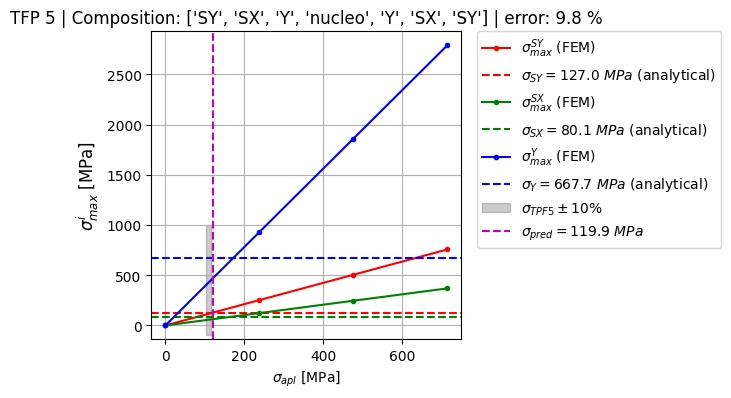

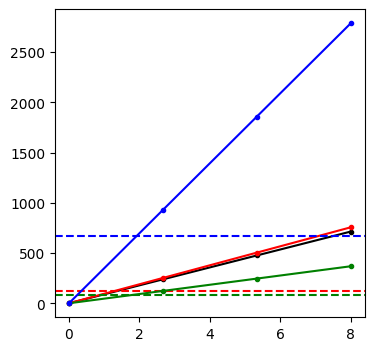

In [93]:
PostProcessing(4)

['SY', 'X', 'Y', 'nucleo', 'Y', 'X', 'SY']


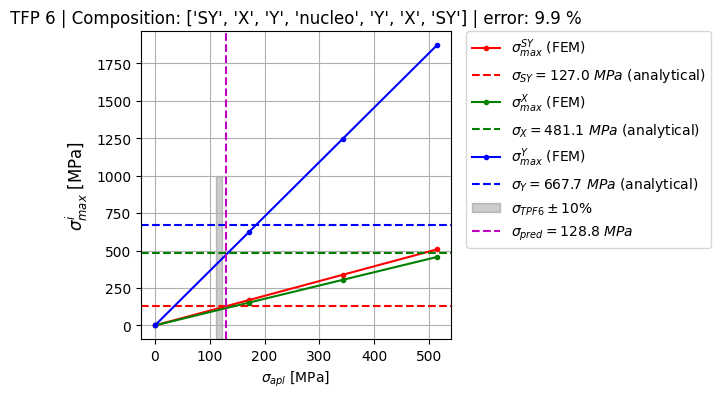

In [ ]:
PostProcessing(5)